In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid
import numpy as np
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from diffusers import UNet2DModel
from torch import amp
import os
import time
import copy

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
print(device)

cpu


In [4]:
transforms = transforms.Compose([transforms.ToTensor(),transforms.Pad(2), transforms.Normalize(0.5, 0.5)])

In [5]:
train_ds = torchvision.datasets.FashionMNIST(root = './data/train',train = True,download = True,transform = transforms)
valid_ds = torchvision.datasets.FashionMNIST(root = './data/valid',train = False,download = True,transform = transforms)

In [6]:
train_loader = torch.utils.data.DataLoader(dataset=train_ds, batch_size = 32, shuffle = True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_ds, batch_size = 32, shuffle = False)
print(len(train_loader))
print(len(valid_loader))

1875
313


In [7]:
# Define in-channels and out-channels as we have grayscale images and also change the out channels as we don't need a model as large as the default configuration

unet_model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 128),norm_num_groups=8, add_attention=(True, False, False, True))

In [8]:
class Unet(nn.Module):
    def __init__(self, model):
        super(Unet, self).__init__()
        self.model = model
    
    def forward(self, x):
        return self.model.forward(*x).sample

In [9]:
class DiffusionParams():
    def __init__(self):
        self.T = 1000
        self.beta = torch.linspace(start = 1e-4, end = 0.02, steps = self.T, dtype = torch.float32, device = device)
        self.alpha = 1 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim = 0)

In [10]:
def forward_process(dp: DiffusionParams, x0: torch.Tensor, t: torch.Tensor):
    epsilon = torch.randn_like(x0)
    mean = torch.sqrt(dp.alpha_bar[t-1])
    mean = mean.view(-1, 1, 1, 1)
    std_dev = torch.sqrt(1 - dp.alpha_bar[t-1])
    std_dev = std_dev.view(-1, 1, 1, 1)
    return mean*x0 + std_dev*epsilon, epsilon


### FORWARD DIFFUSION 

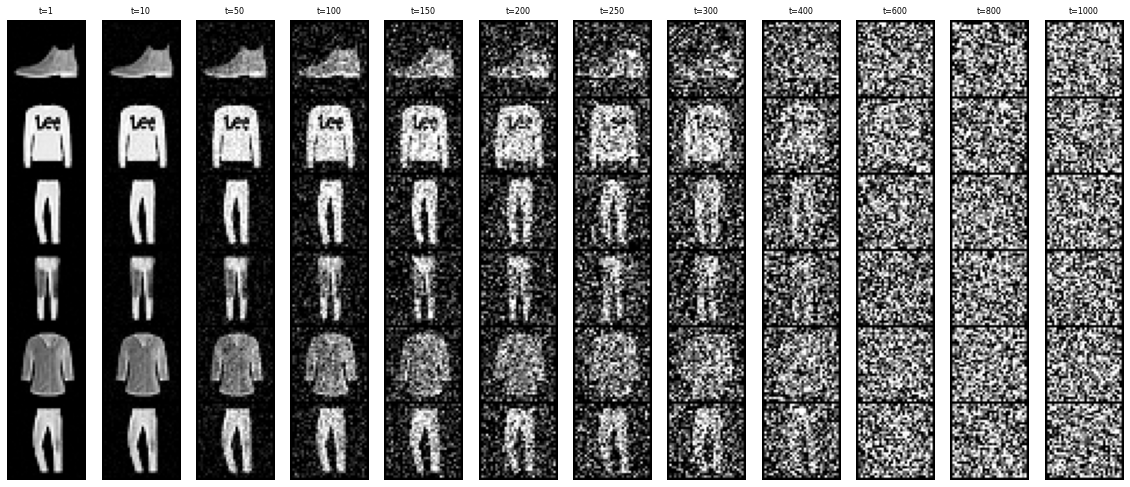

In [11]:
dp = DiffusionParams()
batch = next(iter(valid_loader))
images,labels = batch
batch = images.to(device), labels.to(device)
x0s = images[:6]
x0s = x0s.to(device)
noisy_images = []
specific_timesteps = [1, 10, 50, 100, 150, 200, 250, 300, 400, 600, 800, 1000]
for timestep in specific_timesteps:
    timestep = torch.as_tensor(timestep, dtype=torch.long)
 
    xts, _ = forward_process(dp, x0s, timestep)
    xts    = (xts.clamp(-1, 1)+1.0)/2.0
    xts    = make_grid(xts, nrow=1, padding=1)
     
    noisy_images.append(xts)

_, ax = plt.subplots(1, len(noisy_images), figsize=(20, 10), facecolor='white')
 
for i, (timestep, noisy_sample) in enumerate(zip(specific_timesteps, noisy_images)):
    noisy_sample=noisy_sample.to('cpu')
    ax[i].imshow(noisy_sample.squeeze(0).permute(1, 2, 0))
    ax[i].set_title(f"t={timestep}", fontsize=8)
    ax[i].axis("off")
    ax[i].grid(False)
 
plt.axis("off")
plt.show()


### SAMPLING FUNCTION

In [12]:
@torch.no_grad()
def sample(model):
    xT = torch.randn((6, 1, 32, 32), device = device)
    x_t_1 = xT
    model.eval()
    for i in range(1000, 0, -1):
        z = torch.randn_like(xT, device=device) if i != 1 else torch.zeros_like(xT, device = device)
        ts = torch.ones(6, dtype=torch.long, device=device) * (i-1)
        noise_pred = model((x_t_1, ts))
        t1 = 1/(torch.sqrt(dp.alpha[ts])).view(-1, 1, 1, 1)
        t2 = (1-dp.alpha[ts]).view(-1, 1, 1, 1)
        t3 = (torch.sqrt(1-dp.alpha_bar[ts])).view(-1, 1, 1, 1)
        t4 = (dp.beta[ts]).view(-1, 1, 1, 1)
        x_t_1 = (t1)*((x_t_1) - ((t2)/(t3))*(noise_pred)) + t4*z
    
    imgs = []
    for i in x_t_1:
        imgs.append(i)
    return imgs


### TRAINING

In [13]:
model = Unet(unet_model).to(device)
lr = 2e-4
optimizer = torch.optim.Adam(model.parameters(), lr = 2e-4)
criterion = nn.MSELoss()
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer ,max_lr = lr,epochs = 20,steps_per_epoch = len(train_loader))

In [14]:
num_epochs = 10
generated_images = []
for epoch in range(num_epochs):
    mean_train_loss = 0
    i = 0
    for images, _ in train_loader:
        images = images.to(device)
        t = torch.randint(low = 1, high= dp.T, size = (images.shape[0],), device = device)
        xt, eps = forward_process(dp, images, t)
        loss = criterion(eps, model((xt, t-1)))
        loss.backward()
        optimizer.step()
        #sscheduler.step()
        optimizer.zero_grad()
        mean_train_loss += (loss.item()/32)
    print(f"Epoch: {epoch+1}/{10}: Train Loss : {mean_train_loss}")
torch.save(model,'diffusion.pth')

KeyboardInterrupt: 

In [ ]:
generated_images = sample(model)

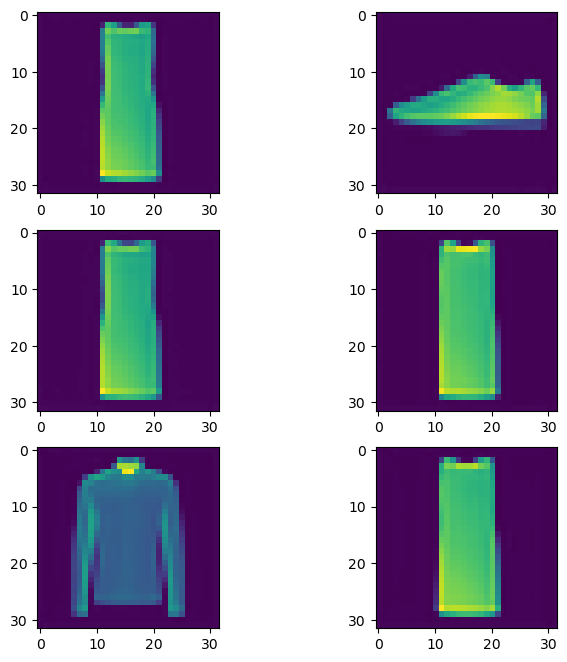

In [31]:
w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 2
rows = 3
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(generated_images[i-1].permute(1, 2, 0).cpu().numpy())
plt.show()
